In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# ---------- CONFIG ----------
csv_path = "train.csv"   # or "/mnt/data/train.csv"
alpha = 0.05             # significance level
maxlag = 12              # cap search to keep it fast/memory-safe
autolag = "AIC"          # AIC/BIC/t-stat or None

# ---------- LOAD ----------
df = pd.read_csv(csv_path)
num_df = df.select_dtypes(include=[np.number]).copy()  # only numeric columns

# ---------- ADF UTILS ----------
def adf_summary(series, name, alpha=0.05, maxlag=12, autolag="AIC", regression="c"):
    """
    Run ADF on one series and return a dict of useful fields.
    regression: 'c' (constant), 'ct' (constant+trend), 'ctt' (constant+trend+quad), 'n' (no constant)
    """
    s = pd.to_numeric(series, errors="coerce").dropna().astype("float32")

    # Guard: too-short or (near) constant series cause ADF to fail
    if len(s) < 20 or np.isclose(np.nanstd(s), 0.0):
        return {
            "variable": name, "n": int(len(s)),
            "adf_stat": np.nan, "p_value": np.nan, "usedlag": np.nan,
            "crit_1%": np.nan, "crit_5%": np.nan, "crit_10%": np.nan,
            "regression": regression, f"is_stationary@{alpha}": np.nan,
            "note": "too few observations or near-constant"
        }

    try:
        stat, pval, usedlag, nobs, crit, icbest = adfuller(
            s.values, maxlag=maxlag, autolag=autolag, regression=regression
        )
        return {
            "variable": name,
            "n": int(nobs),
            "adf_stat": float(stat),
            "p_value": float(pval),
            "usedlag": int(usedlag),
            "crit_1%": crit.get("1%", np.nan),
            "crit_5%": crit.get("5%", np.nan),
            "crit_10%": crit.get("10%", np.nan),
            "icbest": float(icbest) if autolag else np.nan,
            "regression": regression,
            f"is_stationary@{alpha}": bool(pval < alpha),
        }
    except Exception as e:
        return {
            "variable": name, "n": int(len(s)),
            "adf_stat": np.nan, "p_value": np.nan, "usedlag": np.nan,
            "crit_1%": np.nan, "crit_5%": np.nan, "crit_10%": np.nan,
            "regression": regression, f"is_stationary@{alpha}": np.nan,
            "error": str(e)
        }

# ---------- RUN ADF ACROSS COLUMNS ----------
rows = []
for col in num_df.columns:
    res = adf_summary(num_df[col], col, alpha=alpha, maxlag=maxlag, autolag=autolag, regression="c")
    rows.append(res)

adf_df = pd.DataFrame(rows).sort_values("p_value", na_position="last").reset_index(drop=True)

# ---------- VIEW ----------
display_cols = ["variable", "n", "adf_stat", "p_value", "usedlag", "crit_5%", f"is_stationary@{alpha}", "regression"]
print(adf_df[display_cols].to_string(index=False))

# Optional: save for reporting
adf_df.to_csv("adf_results_train.csv", index=False)


variable     n    adf_stat  p_value  usedlag   crit_5%  is_stationary@0.05 regression
       A 79987  -27.588291 0.000000       12 -2.861576                True          c
       B 79987  -39.557066 0.000000       12 -2.861576                True          c
       C 79987  -79.681265 0.000000       12 -2.861576                True          c
       D 79987  -43.017830 0.000000       12 -2.861576                True          c
       F 79987  -42.148249 0.000000       12 -2.861576                True          c
       E 79988  -84.095741 0.000000       11 -2.861576                True          c
       G 79988  -82.229956 0.000000       11 -2.861576                True          c
       H 79992 -101.808361 0.000000        7 -2.861576                True          c
       L 79987  -37.642873 0.000000       12 -2.861576                True          c
       I 79988  -44.686030 0.000000       11 -2.861576                True          c
       J 79992 -101.133482 0.000000        7 -2.861576

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic

# 1) Load & index by time
train = pd.read_csv("train.csv", parse_dates=["time"])
train = train.sort_values("time").set_index("time")

# (optional but often helpful) Standardize columns using TRAIN stats
# Keep a copy of means/stds to apply to test later if you forecast out-of-sample
means = train.mean()
stds  = train.std(ddof=0).replace(0, 1.0)
train_z = (train - means) / stds

# 2) Lag-order selection
sel = VAR(train_z).select_order(maxlags=24)  # try up to 24 lags (adjust as you like)
print("Selected lags:", {k: v for k, v in sel.__dict__.items() if k.endswith("_opt")})
p = sel.aic  # or sel.bic / sel.hqic / sel.fpe

# 3) Fit VAR(p)
var = VAR(train_z).fit(p)
print(var.summary())

# 4) Residual diagnostics
# Durbin–Watson per series (values near 2 are good; <<2 means positive autocorr)
dw = durbin_watson(var.resid)
print("\nDurbin-Watson by variable:")
for name, val in zip(train_z.columns, dw):
    print(f"{name:>8s}: {val:.3f}")

# (Optional) Ljung-Box on residuals could be added for stronger autocorr checks

# 5) In-sample one-step RMSE for a quick sanity check
fitted = var.fittedvalues  # aligned to start at t = p+1
common_cols = ["Y1", "Y2"]
rmse_y1 = rmse(train_z["Y1"].iloc[p:], fitted["Y1"])
rmse_y2 = rmse(train_z["Y2"].iloc[p:], fitted["Y2"])
print(f"\nIn-sample RMSE (z-scored) — Y1: {rmse_y1:.4f}, Y2: {rmse_y2:.4f}")

# 6) (If you have test.csv for out-of-sample) Forecast forward
#    Align test index and inverse-transform back to original scale
try:
    test = pd.read_csv("test.csv", parse_dates=["time"]).sort_values("time").set_index("time")
    test_z_exog = None  # not used in plain VAR

    steps = len(test)
    # Forecast in standardized space
    fcst_z = var.forecast(y=train_z.values[-p:], steps=steps)
    fcst_z = pd.DataFrame(fcst_z, index=test.index, columns=train_z.columns)

    # Inverse standardize
    fcst = fcst_z * stds + means

    # Evaluate on Y1, Y2 where available
    if {"Y1","Y2"}.issubset(test.columns):
        y1_rmse = rmse(test["Y1"].iloc[:steps], fcst["Y1"].iloc[:steps])
        y2_rmse = rmse(test["Y2"].iloc[:steps], fcst["Y2"].iloc[:steps])
        print(f"\nOut-of-sample RMSE — Y1: {y1_rmse:.4f}, Y2: {y2_rmse:.4f}")

    # Optional: save forecasts
    fcst[["Y1","Y2"]].to_csv("var_forecast_y1y2.csv")
except FileNotFoundError:
    print("\nNo test.csv found; ran in-sample only.")


C:\Users\Enzo\AppData\Local\Temp\ipykernel_55908\1085460294.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train = pd.read_csv("train.csv", parse_dates=["time"])
c:\Enzo_Files\25Wk37 Quant Trading\venv_Quant\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Enzo_Files\25Wk37 Quant Trading\venv_Quant\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Selected lags: {}


c:\Enzo_Files\25Wk37 Quant Trading\venv_Quant\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Enzo_Files\25Wk37 Quant Trading\venv_Quant\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 22, Sep, 2025
Time:                     21:12:36
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                   -13.7152
Nobs:                     79976.0    HQIC:                  -14.2113
Log likelihood:      -1.23248e+06    FPE:                5.40553e-07
AIC:                     -14.4307    Det(Omega_mle):     5.00574e-07
--------------------------------------------------------------------
Results for equation A
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000002         0.002281            0.001           0.999
L1.A           0.053937         0.004373           12.335           0.000
L1.B          -0.014343         0.004114           -3.486           0.000
L1.C          -0.0

C:\Users\Enzo\AppData\Local\Temp\ipykernel_55908\1085460294.py:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test = pd.read_csv("test.csv", parse_dates=["time"]).sort_values("time").set_index("time")


C:\Users\Enzo\AppData\Local\Temp\ipykernel_55908\1974071204.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("train.csv", parse_dates=["time"]).sort_values("time").set_index("time")
c:\Enzo_Files\25Wk37 Quant Trading\venv_Quant\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Enzo_Files\25Wk37 Quant Trading\venv_Quant\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Lag order candidates: {'aic': np.int64(12), 'bic': np.int64(11), 'hqic': np.int64(12), 'fpe': np.int64(12)}  -> using p = 2


c:\Enzo_Files\25Wk37 Quant Trading\venv_Quant\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Enzo_Files\25Wk37 Quant Trading\venv_Quant\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                           Statespace Model Results                           
Dep. Variable:           ['Y1', 'Y2']   No. Observations:                64000
Model:                        VARX(2)   Log Likelihood             -100851.700
                          + intercept   AIC                         201785.401
Date:                Mon, 22 Sep 2025   BIC                         202157.133
Time:                        21:53:27   HQIC                        201900.524
Sample:                             0                                         
                              - 64000                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):          2.03, 2078.75   Jarque-Bera (JB):   16866836.46, 25391001.02
Prob(Q):                        0.15, 0.00   Prob(JB):                         0.00, 0.00
Heteroskedasticity (H):         2.73, 1.20   Skew:                             1.92, 4.90
Prob(H) (two-sided)

c:\Enzo_Files\25Wk37 Quant Trading\venv_Quant\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Enzo_Files\25Wk37 Quant Trading\venv_Quant\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


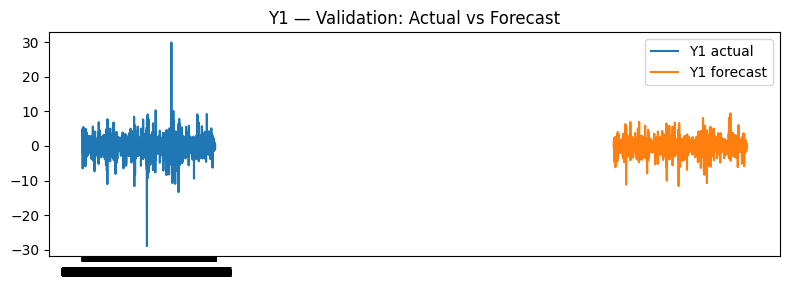

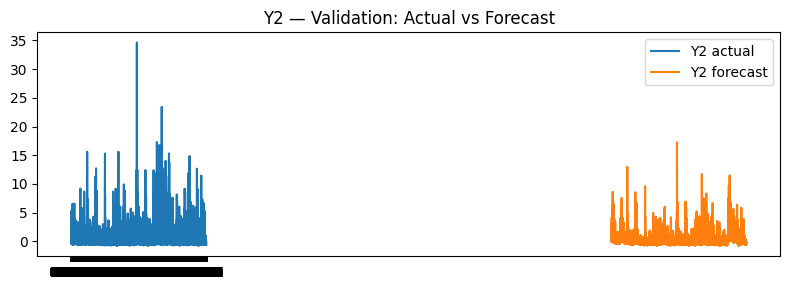

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse

# ---------- 1) Load & time-sort ----------
df = pd.read_csv("train.csv", parse_dates=["time"]).sort_values("time").set_index("time")

endog_cols = ["Y1", "Y2"]
exog_cols  = [c for c in df.columns if c not in endog_cols]

# ---------- 2) Chronological split (last 20% = validation) ----------
val_frac = 0.2
split_idx = int(len(df) * (1 - val_frac))

train_df = df.iloc[:split_idx].copy()
val_df   = df.iloc[split_idx:].copy()

# ---------- 3) Standardize using TRAIN stats only ----------
endog_tr = train_df[endog_cols].copy()
exog_tr  = train_df[exog_cols].copy()
endog_va = val_df[endog_cols].copy()
exog_va  = val_df[exog_cols].copy()

e_mean, e_std = endog_tr.mean(), endog_tr.std(ddof=0).replace(0, 1.0)
x_mean, x_std = exog_tr.mean(),  exog_tr.std(ddof=0).replace(0, 1.0)

endog_tr_z = (endog_tr - e_mean) / e_std
exog_tr_z  = (exog_tr  - x_mean) / x_std
endog_va_z = (endog_va - e_mean) / e_std
exog_va_z  = (exog_va  - x_mean) / x_std

# ---------- 4) Choose lag order p (reuse VAR order selection as a proxy) ----------
# We use all variables (endog+exog) to gauge temporal depth, capped to keep it fast.
maxlags = 12
sel = VAR(pd.concat([endog_tr_z, exog_tr_z], axis=1)).select_order(maxlags=maxlags)
p_candidates = dict(aic=sel.aic, bic=sel.bic, hqic=sel.hqic, fpe=sel.fpe)
p = p_candidates["aic"] if isinstance(p_candidates["aic"], int) else 2  # fallback
print("Lag order candidates:", p_candidates, " -> using p =", p)

# ---------- 5) Fit VARMAX on TRAIN ----------
model = VARMAX(endog=endog_tr_z, exog=exog_tr_z, order=(p, 0), trend="c", enforce_stationarity=True)
res = model.fit(disp=False)
print(res.summary())

# ---------- 6) Forecast VALIDATION horizon using known exog ----------
steps = len(val_df)
fcst_z = res.get_forecast(steps=steps, exog=exog_va_z).predicted_mean
fcst   = fcst_z * e_std + e_mean  # inverse standardize to original scale

# ---------- 7) Evaluate on Y1, Y2 ----------
def mae(y_true, y_pred): 
    return np.mean(np.abs(y_true - y_pred))

metrics = {}
for y in endog_cols:
    metrics[(y, "RMSE")] = rmse(val_df[y], fcst[y])
    metrics[(y, "MAE")]  = mae(val_df[y], fcst[y])

print("\nValidation metrics:")
for (y, m), v in metrics.items():
    print(f"{y:>2s} {m}: {v:.6f}")

# ---------- 8) (Optional) Plot actual vs forecast for validation ----------
import matplotlib.pyplot as plt

for y in endog_cols:
    plt.figure(figsize=(8,3))
    plt.plot(val_df.index, val_df[y].values, label=f"{y} actual")
    plt.plot(fcst.index,   fcst[y].values,   label=f"{y} forecast")
    plt.title(f"{y} — Validation: Actual vs Forecast")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 9) Save forecasts ----------
fcst.to_csv("varmax_val_forecast_y1y2.csv")
